# Baseline testing

In [161]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.exceptions import ConvergenceWarning
from sklearn.utils import _testing

In [162]:
## Constant
RANDOM_STATE = 0

## Data preparation

In [163]:
## Read csv file
df = pd.read_csv('train_all_tasks.csv')

### train/dev/test split

In [164]:
# text and labels for task A
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(df['text'], df['label_sexist'], test_size=0.3, random_state=RANDOM_STATE)
X_test_a, X_dev_a, y_test_a, y_dev_a = train_test_split(X_test_a, y_test_a, test_size=0.33, random_state=RANDOM_STATE)

# text and labels for task B
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(df[df['label_sexist'] == 'sexist']['text'],
                                                                df[df['label_sexist'] == 'sexist']['label_category'],
                                                                test_size=0.3,
                                                                random_state=RANDOM_STATE)
X_test_b, X_dev_b, y_test_b, y_dev_b = train_test_split(X_test_b, y_test_b, test_size=0.33, random_state=RANDOM_STATE)

In [165]:
print(Counter(y_train_a))
print(Counter(y_dev_a))
print(Counter(y_test_a))
print("")
print(Counter(y_train_b))
print(Counter(y_dev_b))
print(Counter(y_test_b))

Counter({'not sexist': 7413, 'sexist': 2387})
Counter({'not sexist': 1058, 'sexist': 328})
Counter({'not sexist': 2131, 'sexist': 683})

Counter({'2. derogation': 1107, '3. animosity': 812, '1. threats, plans to harm and incitement': 231, '4. prejudiced discussions': 228})
Counter({'2. derogation': 157, '3. animosity': 115, '4. prejudiced discussions': 37, '1. threats, plans to harm and incitement': 28})
Counter({'2. derogation': 326, '3. animosity': 238, '4. prejudiced discussions': 68, '1. threats, plans to harm and incitement': 51})


### Output formatting

In [166]:
def confmatrix_display(confmatrix, model_name, task_name):
    plt.rcParams.update({'font.size': 12})
    plt.figure(dpi=1200)

    if task_name == 'taskA':
        labels = df['label_sexist'].unique() 
    else:
        labels = df[df['label_sexist'] == 'sexist']['label_category'].sort_values().unique()
        labels[0] = '1. threats...'

    cm_display = ConfusionMatrixDisplay(confmatrix, display_labels=labels).plot()
    # cm_display = ConfusionMatrixDisplay(confmatrix).plot()
    
    if task_name != 'taskA':
        plt.xticks(rotation=45, ha='right')

In [167]:
def report(model_name, ydev, pred, task_name, zero_division=1):
    conf_matrix = confusion_matrix(ydev, pred)
    print("\n=== {0} ===\n\nClassification Report:\n{1}"
          "\nConfusion Matrix:\n{2}".format(model_name,
                                            classification_report(ydev, pred, 
                                                                  zero_division=zero_division),
                                            confusion_matrix(ydev, pred)))

    confmatrix_display(conf_matrix, model_name, task_name)

### Model setup

In [168]:
def naive_bayes(xtrain, ytrain, xdev, ydev, le, task_name):
  model_name = "naive bayes"
  model = MultinomialNB()
  vec = CountVectorizer()

  vec.fit(xtrain, xdev)
  xtrain_enc = vec.transform(xtrain)
  xdev_enc = vec.transform(xdev)

  model.fit(xtrain_enc, ytrain)
  pred = model.predict(xdev_enc)
  pred = le.inverse_transform(pred)

  report(model_name, ydev, pred, task_name)

In [169]:
def svm_train(xtrain, ytrain, xdev, ydev, le, task_name):
  model_name = "SVM"
  model = SVC(kernel='linear', random_state=RANDOM_STATE)
  vec = CountVectorizer()

  vec.fit(xtrain, xdev)
  xtrain_enc = vec.transform(xtrain)
  xdev_enc = vec.transform(xdev)

  model.fit(xtrain_enc, ytrain)
  pred = model.predict(xdev_enc)
  pred = le.inverse_transform(pred)

  report(model_name, ydev, pred, task_name)

In [170]:
def majority_class(xtrain, ytrain, xdev, ydev, le, task_name):
  model_name = "majority class"
  model = DummyClassifier(random_state=RANDOM_STATE)
  vec = CountVectorizer()

  vec.fit(xtrain, xdev)
  xtrain_enc = vec.transform(xtrain)
  xdev_enc = vec.transform(xdev)

  model.fit(xtrain_enc, ytrain)
  pred = model.predict(xdev_enc)
  pred = le.inverse_transform(pred)

  report(model_name, ydev, pred, task_name, zero_division=0)

In [171]:
def decision_tree_train(xtrain, ytrain, xdev, ydev, le, task_name):
  model_name = "decision tree"
  model = DecisionTreeClassifier(random_state=RANDOM_STATE)
  vec = CountVectorizer()

  vec.fit(xtrain, xdev)
  xtrain_enc = vec.transform(xtrain)
  xdev_enc = vec.transform(xdev)

  model.fit(xtrain_enc, ytrain)
  pred = model.predict(xdev_enc)
  pred = le.inverse_transform(pred)

  report(model_name, ydev, pred, task_name)

In [172]:
@_testing.ignore_warnings(category=ConvergenceWarning)
def logistic_regression(xtrain, ytrain, xdev, ydev, le, task_name):
  model_name = "logistic regression"
  model = LogisticRegression(random_state=RANDOM_STATE)
  vec = CountVectorizer()

  vec.fit(xtrain, xdev)
  xtrain_enc = vec.transform(xtrain)
  xdev_enc = vec.transform(xdev)

  model.fit(xtrain_enc, ytrain)
  pred = model.predict(xdev_enc)
  pred = le.inverse_transform(pred)

  report(model_name, ydev, pred, task_name)

In [173]:
from sklearn.ensemble import StackingClassifier

@_testing.ignore_warnings(category=ConvergenceWarning)
def stacking_classifier(xtrain, ytrain, xdev, ydev, le, task_name):
  model_name = "stacking classifier"

  estimators = [('dt', DecisionTreeClassifier(random_state=RANDOM_STATE)),
                ('svc', SVC(kernel='linear', random_state=RANDOM_STATE)),
                ('nb', MultinomialNB()),
                ('lr', LogisticRegression(random_state=RANDOM_STATE))]
  model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=RANDOM_STATE))


  vec = CountVectorizer()

  vec.fit(xtrain, xdev)
  xtrain_enc = vec.transform(xtrain)
  xdev_enc = vec.transform(xdev)

  model.fit(xtrain_enc, ytrain)
  pred = model.predict(xdev_enc)
  pred = le.inverse_transform(pred)

  report(model_name, ydev, pred, task_name)

## Running Task A (Binary) 

In [174]:
task_name = 'taskA'
le = LabelEncoder()

le.fit(y_train_a)
y_train_a = le.transform(y_train_a)

### Naive Bayes


=== naive bayes ===

Classification Report:
              precision    recall  f1-score   support

  not sexist       0.82      0.95      0.88      2131
      sexist       0.70      0.35      0.46       683

    accuracy                           0.81      2814
   macro avg       0.76      0.65      0.67      2814
weighted avg       0.79      0.81      0.78      2814

Confusion Matrix:
[[2029  102]
 [ 446  237]]


<Figure size 7200x4800 with 0 Axes>

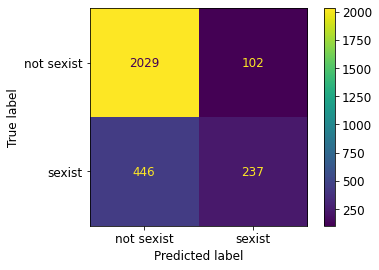

In [175]:
naive_bayes(X_train_a, y_train_a, X_test_a, y_test_a, le, task_name)

### Majority class


=== majority class ===

Classification Report:
              precision    recall  f1-score   support

  not sexist       0.76      1.00      0.86      2131
      sexist       0.00      0.00      0.00       683

    accuracy                           0.76      2814
   macro avg       0.38      0.50      0.43      2814
weighted avg       0.57      0.76      0.65      2814

Confusion Matrix:
[[2131    0]
 [ 683    0]]


<Figure size 7200x4800 with 0 Axes>

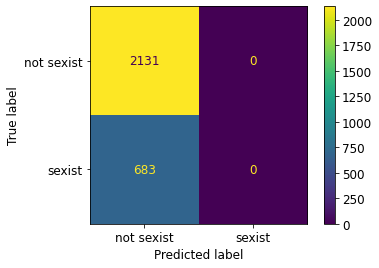

In [176]:
majority_class(X_train_a, y_train_a, X_test_a, y_test_a, le, task_name)

### SVM


=== SVM ===

Classification Report:
              precision    recall  f1-score   support

  not sexist       0.86      0.89      0.87      2131
      sexist       0.61      0.54      0.57       683

    accuracy                           0.81      2814
   macro avg       0.74      0.72      0.72      2814
weighted avg       0.80      0.81      0.80      2814

Confusion Matrix:
[[1899  232]
 [ 314  369]]


<Figure size 7200x4800 with 0 Axes>

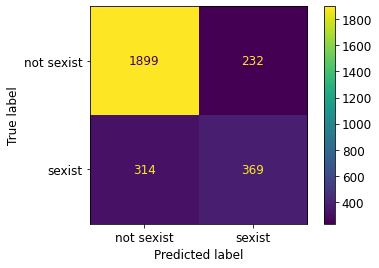

In [177]:
svm_train(X_train_a, y_train_a, X_test_a, y_test_a, le, task_name)

### Decision tree


=== decision tree ===

Classification Report:
              precision    recall  f1-score   support

  not sexist       0.86      0.88      0.87      2131
      sexist       0.60      0.53      0.56       683

    accuracy                           0.80      2814
   macro avg       0.73      0.71      0.72      2814
weighted avg       0.79      0.80      0.80      2814

Confusion Matrix:
[[1885  246]
 [ 319  364]]


<Figure size 7200x4800 with 0 Axes>

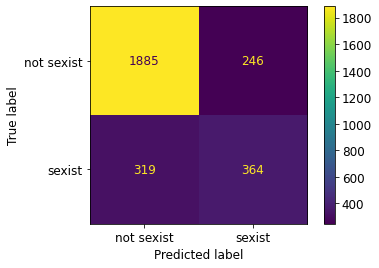

In [178]:
decision_tree_train(X_train_a, y_train_a, X_test_a, y_test_a, le, task_name)

### Logistic regression


=== logistic regression ===

Classification Report:
              precision    recall  f1-score   support

  not sexist       0.85      0.94      0.89      2131
      sexist       0.72      0.48      0.58       683

    accuracy                           0.83      2814
   macro avg       0.78      0.71      0.74      2814
weighted avg       0.82      0.83      0.82      2814

Confusion Matrix:
[[2001  130]
 [ 352  331]]


<Figure size 7200x4800 with 0 Axes>

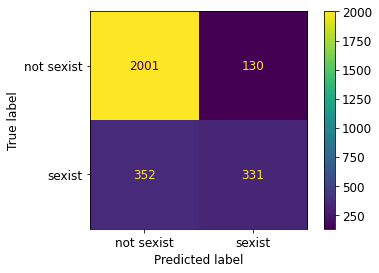

In [179]:
logistic_regression(X_train_a, y_train_a, X_test_a, y_test_a, le, task_name)

### Stacking classifier


=== stacking classifier ===

Classification Report:
              precision    recall  f1-score   support

  not sexist       0.85      0.95      0.90      2131
      sexist       0.76      0.48      0.59       683

    accuracy                           0.84      2814
   macro avg       0.81      0.72      0.74      2814
weighted avg       0.83      0.84      0.82      2814

Confusion Matrix:
[[2030  101]
 [ 356  327]]


<Figure size 7200x4800 with 0 Axes>

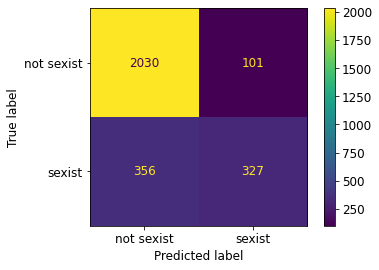

In [180]:
stacking_classifier(X_train_a, y_train_a, X_test_a, y_test_a, le, task_name)

## Running Task B (Multi-class) 

In [181]:
task_name = 'taskB'

le.fit(y_train_b)
y_train_b = le.transform(y_train_b)

### Naive Bayes


=== naive bayes ===

Classification Report:
                                          precision    recall  f1-score   support

1. threats, plans to harm and incitement       1.00      0.10      0.18        51
                           2. derogation       0.53      0.84      0.65       326
                            3. animosity       0.46      0.30      0.36       238
               4. prejudiced discussions       0.75      0.04      0.08        68

                                accuracy                           0.52       683
                               macro avg       0.68      0.32      0.32       683
                            weighted avg       0.56      0.52      0.46       683

Confusion Matrix:
[[  5  32  14   0]
 [  0 273  52   1]
 [  0 167  71   0]
 [  0  48  17   3]]


<Figure size 7200x4800 with 0 Axes>

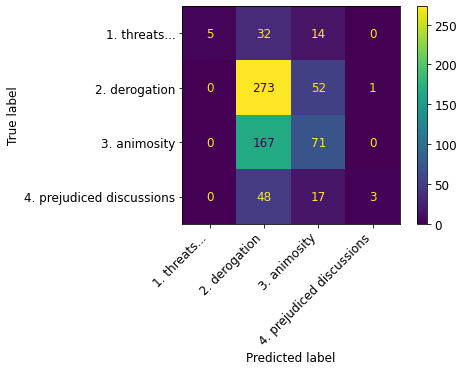

In [182]:
naive_bayes(X_train_b, y_train_b, X_test_b, y_test_b, le, task_name)

### Majority class


=== majority class ===

Classification Report:
                                          precision    recall  f1-score   support

1. threats, plans to harm and incitement       0.00      0.00      0.00        51
                           2. derogation       0.48      1.00      0.65       326
                            3. animosity       0.00      0.00      0.00       238
               4. prejudiced discussions       0.00      0.00      0.00        68

                                accuracy                           0.48       683
                               macro avg       0.12      0.25      0.16       683
                            weighted avg       0.23      0.48      0.31       683

Confusion Matrix:
[[  0  51   0   0]
 [  0 326   0   0]
 [  0 238   0   0]
 [  0  68   0   0]]


<Figure size 7200x4800 with 0 Axes>

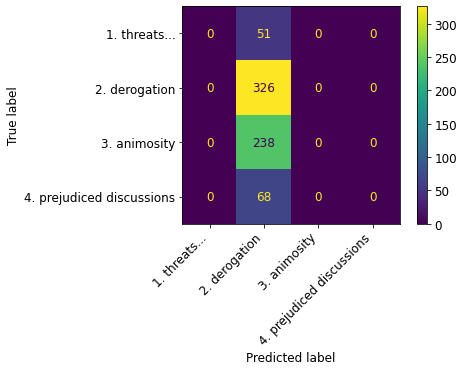

In [183]:
majority_class(X_train_b, y_train_b, X_test_b, y_test_b, le, task_name)

### SVM


=== SVM ===

Classification Report:
                                          precision    recall  f1-score   support

1. threats, plans to harm and incitement       0.39      0.53      0.45        51
                           2. derogation       0.55      0.57      0.56       326
                            3. animosity       0.44      0.43      0.44       238
               4. prejudiced discussions       0.27      0.18      0.21        68

                                accuracy                           0.48       683
                               macro avg       0.41      0.43      0.41       683
                            weighted avg       0.47      0.48      0.47       683

Confusion Matrix:
[[ 27   7  12   5]
 [ 26 185 100  15]
 [ 13 110 103  12]
 [  4  33  19  12]]


<Figure size 7200x4800 with 0 Axes>

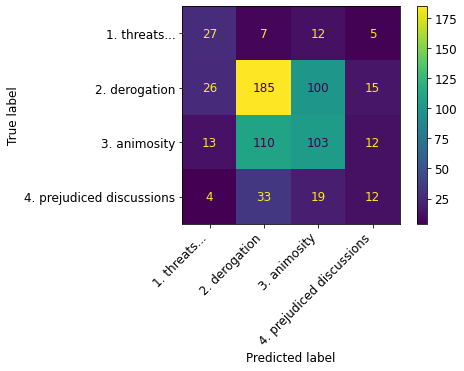

In [184]:
svm_train(X_train_b, y_train_b, X_test_b, y_test_b, le, task_name)

### Decision tree


=== decision tree ===

Classification Report:
                                          precision    recall  f1-score   support

1. threats, plans to harm and incitement       0.26      0.27      0.27        51
                           2. derogation       0.53      0.54      0.54       326
                            3. animosity       0.47      0.47      0.47       238
               4. prejudiced discussions       0.19      0.18      0.18        68

                                accuracy                           0.46       683
                               macro avg       0.36      0.37      0.36       683
                            weighted avg       0.46      0.46      0.46       683

Confusion Matrix:
[[ 14  19  13   5]
 [ 19 177  95  35]
 [ 16  99 111  12]
 [  4  36  16  12]]


<Figure size 7200x4800 with 0 Axes>

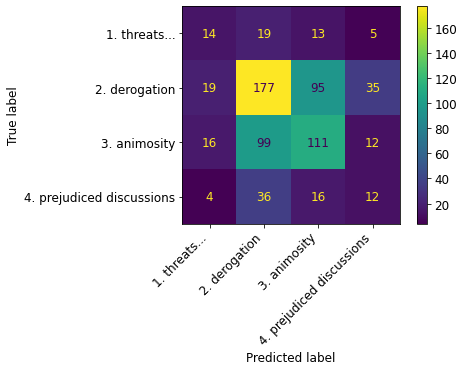

In [185]:
decision_tree_train(X_train_b, y_train_b, X_test_b, y_test_b, le, task_name)

### Logistic regression


=== logistic regression ===

Classification Report:
                                          precision    recall  f1-score   support

1. threats, plans to harm and incitement       0.52      0.43      0.47        51
                           2. derogation       0.57      0.64      0.60       326
                            3. animosity       0.46      0.46      0.46       238
               4. prejudiced discussions       0.32      0.18      0.23        68

                                accuracy                           0.52       683
                               macro avg       0.47      0.43      0.44       683
                            weighted avg       0.50      0.52      0.51       683

Confusion Matrix:
[[ 22   9  15   5]
 [ 12 208  97   9]
 [  5 111 110  12]
 [  3  37  16  12]]


<Figure size 7200x4800 with 0 Axes>

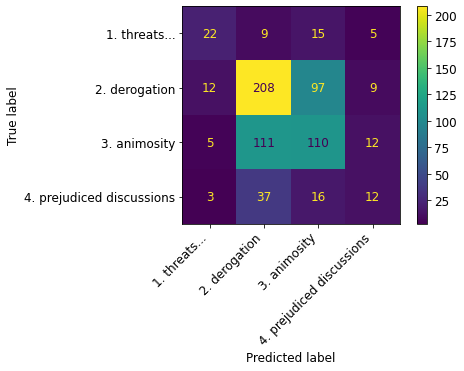

In [186]:
logistic_regression(X_train_b, y_train_b, X_test_b, y_test_b, le, task_name)

### Stacking classifier


=== stacking classifier ===

Classification Report:
                                          precision    recall  f1-score   support

1. threats, plans to harm and incitement       0.54      0.39      0.45        51
                           2. derogation       0.54      0.79      0.64       326
                            3. animosity       0.51      0.29      0.37       238
               4. prejudiced discussions       0.28      0.13      0.18        68

                                accuracy                           0.52       683
                               macro avg       0.47      0.40      0.41       683
                            weighted avg       0.50      0.52      0.49       683

Confusion Matrix:
[[ 20  18   8   5]
 [  9 258  50   9]
 [  5 154  70   9]
 [  3  46  10   9]]


<Figure size 7200x4800 with 0 Axes>

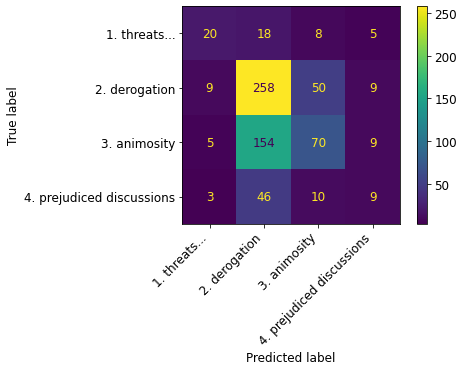

In [187]:
stacking_classifier(X_train_b, y_train_b, X_test_b, y_test_b, le, task_name)